# Bird species image classification

В задаче классификации участвовали фотографии 20 классов:

  - black_kite
  - chaffinch
  - common_magpie
  - common_raven
  - crested_tit
  - eurasian_jay
  - eurasian_pygmy-owl
  - eurasian_tree_sparrow
  - european_turtle-dove
  - great_spotted_woodpecker
  - hazel_grouse
  - northern_harrier
  - rock_pigeon
  - ruddy_shelduck
  - snow_goose
  - snowy_owl
  - waxwing
  - white_stork
  - white_wagtail
  - willow_grouse


In [ ]:
!pip install efficientnet_pytorch

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
import PIL
from pathlib import Path
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
from datetime import date
import random

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "/content/drive/MyDrive/bird_species"

/content/drive/MyDrive/bird_species


В задаче классификации участвовали фотографии 20 классов (фотографии были собраны из google images по английским названиям.

In [ ]:
BATCH_SIZE = 40
EPOCHES = 5
lr=1e-5
IMG_SIZE = [256, 256]
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# 1 Classification

## 1.1 Dataset & dataloader

Фотографии находятся в папках своего класса без разделения на тестовую и обучающую выборки.

In [ ]:
img_path = './bird_dataset/bird_class_img' # путь до папки с датасетом

In [ ]:
labels = sorted(os.listdir(img_path))
label_dict = {i:labels[i] for i in range(0, len(labels))}
num_classes = len(label_dict)

In [ ]:
label_dict

{0: 'black_kite',
 1: 'chaffinch',
 2: 'common_magpie',
 3: 'common_raven',
 4: 'crested_tit',
 5: 'eurasian_jay',
 6: 'eurasian_pygmy-owl',
 7: 'eurasian_tree_sparrow',
 8: 'european_turtle-dove',
 9: 'great_spotted_woodpecker',
 10: 'hazel_grouse',
 11: 'northern_harrier',
 12: 'rock_pigeon',
 13: 'ruddy_shelduck',
 14: 'snow_goose',
 15: 'snowy_owl',
 16: 'waxwing',
 17: 'white_stork',
 18: 'white_wagtail',
 19: 'willow_grouse'}

### 1.1.1 Augmentation

In [ ]:
def transform(image, img_size, split):
    # different transformations for 'train' or 'test' splits
    assert split in {'TRAIN', 'TEST'}

    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    new_image = image

    if split == 'TRAIN':
        img_blurrer = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        img_autocontrast = T.RandomAutocontrast(p=0.5)
        rotate = T.RandomRotation(degrees=(0, 90))
        sharpness_adjuster = T.RandomAdjustSharpness(sharpness_factor=2)
        hflip = T.RandomHorizontalFlip(p=0.5)

        new_image = hflip(new_image)

        if random.random() < 0.4:
            new_image = img_blurrer(new_image)
            new_image = img_autocontrast(new_image)
        if random.random() < 0.3:
            new_image = sharpness_adjuster(new_image)
            new_image = rotate(new_image)
            
    base_transform = T.Compose([T.ToTensor(), 
                                T.Resize(img_size), 
                                T.Normalize(mean=mean, std=std)])
    new_image = base_transform(new_image)  

    return new_image
     

In [ ]:
class BirdDataset(Dataset):
    def __init__(self, img_folder, img_size, split):
        super().__init__()
        self.img_folder = img_folder
        self.img_size = img_size
        self.split = split.upper()
        assert self.split in {'TRAIN', 'TEST'}
     
        self.dataset = datasets.ImageFolder(self.img_folder, transform=None)

    def __len__(self):
        return len(self.dataset)
  
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        if image.mode != 'RGB':
            image = image.convert('RGB')  
        image = transform(image, self.img_size, self.split)
        object_label = self.dataset[idx][1]

        return {'image': image, 'label': object_label}

In [ ]:
bird_set = BirdDataset(img_path, IMG_SIZE, split='train')

In [ ]:
def draw_label(label, is_pred=False):
    class_labels = labels
    class_lb = label_dict[label]
    if is_pred:
        colormap = "tab20b"
        V = 'bottom'
    else:
        colormap = "tab20c"
        V = 'top'
    cmap = plt.get_cmap(colormap)
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    text_params = ({'horizontalalignment':'left',
                   'verticalalignment':V,
                   'color':"white",
                   'bbox':{"color": colors[int(label)], 
                           "pad": 0}})
    
    return class_lb, text_params

In [ ]:
def show_img_n_lbl(data_set, is_labels_pred=False):
    f, axes = plt.subplots(2,5, figsize=(14, 6))
    for i in range(2):
        for p in range(5):
            idx = np.random.randint(0, len(data_set))
            img_tensor = data_set[idx]['image']
            label = data_set[idx]['label']
            image = np.moveaxis(img_tensor.numpy(), 0, 2)
            image = image * np.array(std) + np.array(mean)
            
            if is_labels_pred:
                with torch.no_grad():
                    label_pred = model(torch.unsqueeze(img_tensor, dim=0).to(device)).cpu().numpy()[0].argmax()
                                
                class_pred, pred_params = draw_label(label_pred, is_pred=True)
                axes[i][p].text(0, 0, 'pred:'+class_pred ,pred_params)
         
            axes[i][p].axis('off')
            axes[i][p].imshow(image.clip(0, 1))
            class_gt, params = draw_label(label, is_pred=False)
            axes[i][p].text(0, 0, 'gt:'+class_gt, params)


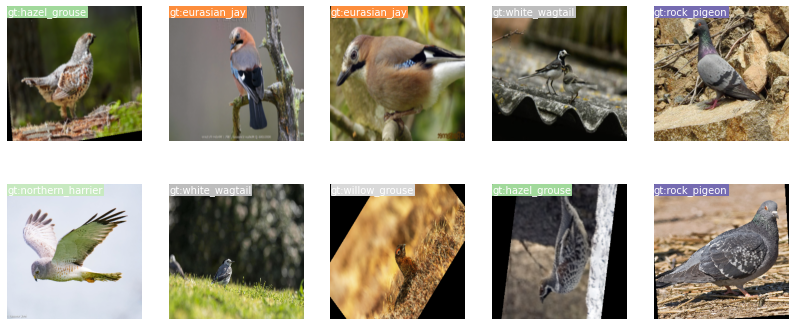

In [ ]:
show_img_n_lbl(bird_set, is_labels_pred=False)

### 1.1.2 Train & val split 

In [ ]:
# train/val split 
train_size = int(0.8 * len(bird_set))
val_size = len(bird_set) - train_size
train_set, val_set = torch.utils.data.random_split(bird_set, 
                                                    [train_size, val_size], 
                                                    generator=torch.Generator().manual_seed(42))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## 1.2 Network architecture

В качестве модели использовалась предобученная [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf)

In [ ]:
def save_checkpoint(model, optimizer, filepath="./checkpoints"):
    # make checkpoint dir 
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    filepath = Path(filepath)
    checkpoint = {'state_dict': model.state_dict(),
                  'optimizer': optimizer.state_dict()}
    today = date.today()
    filename = "my_checkpoint" + str(today) + ".pth.tar"
    print('Saving checkpoint', filename)
    torch.save(checkpoint, filepath/filename)

In [ ]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("Loading checkpoint", checkpoint_file)
    filepath=Path("./checkpoints")
    checkpoint = torch.load(filepath / checkpoint_file)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = EfficientNet.from_name('efficientnet-b0')
model.load_state_dict(torch.load('./efficientnet-b0-08094119.pth'))   # from https://www.kaggle.com/hmendonca/efficientnet-pytorch
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model = model.to(device)

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

In [ ]:
load_checkpoint('my_checkpoint2021-08-21.pth.tar', model, optimizer, lr)

Loading checkpoint my_checkpoint2021-08-21.pth.tar


## 1.3 Model training

In [ ]:
def model_train(train_loader, model, optimizer, loss_fn):
    model.train()
    epoch_loss = 0.
    correct = 0
    total = 0
    train_loop = tqdm(train_loader, position=0, leave=True)
    for batch_idx, batch in enumerate(train_loop):
        images, labels = batch['image'], batch['label']
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(images)
        correct += (labels == predictions.argmax(dim=1,)).sum()
        total += len(labels)

        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        mean_loss = epoch_loss / len(train_loader)
        train_loop.set_postfix({'train_loss':mean_loss}, refresh=True)
    train_loop.close()
    accuracy = correct / total
    print(f"Train accuracy is: {accuracy*100:2f}%")
    return epoch_loss

def val_model(val_loader, model, optimizer, loss_fn):
    model.eval()
    epoch_loss = 0.
    correct = 0
    total = 0
    val_loop = tqdm(val_loader, position=0, leave=True)
    for batch_idx, batch in enumerate(val_loop):
        images, labels = batch['image'], batch['label']
        images = images.to(device)
        labels = labels.to(device)

        predictions = model(images)
        correct += sum((labels == predictions.argmax(dim=1,)))
        total += len(labels)
        with torch.no_grad():
            loss = loss_function(predictions, labels)

        epoch_loss += loss.item()
        mean_loss = epoch_loss / len(val_loader)
        
        val_loop.set_postfix({'val_loss':mean_loss}, refresh=True)
    val_loop.close()
    accuracy = correct / total
    print(f"Val accuracy is: {accuracy*100:2f}%")
    return epoch_loss


In [ ]:
train_loss_per_epoche = []
val_loss_per_epoche = []

In [ ]:
for epoch in range(EPOCHES):
    print('Epoch {}/{}'.format(epoch + 1, EPOCHES))

    train_loss = model_train(train_loader, model, optimizer, loss_function)
    val_loss = val_model(val_loader, model, optimizer, loss_function)
    train_loss_per_epoche.append(train_loss)
    val_loss_per_epoche.append(val_loss)

Epoch 1/5


100%|██████████| 109/109 [05:17<00:00,  2.91s/it, train_loss=0.469]


Train accuracy is: 92.422844%


100%|██████████| 28/28 [01:22<00:00,  2.94s/it, val_loss=0.373]


Val accuracy is: 94.198898%
Epoch 2/5


100%|██████████| 109/109 [05:48<00:00,  3.19s/it, train_loss=0.425]


Train accuracy is: 92.952553%


100%|██████████| 28/28 [01:29<00:00,  3.20s/it, val_loss=0.34]


Val accuracy is: 94.014732%
Epoch 3/5


100%|██████████| 109/109 [05:34<00:00,  3.07s/it, train_loss=0.397]


Train accuracy is: 92.998619%


100%|██████████| 28/28 [01:28<00:00,  3.17s/it, val_loss=0.311]


Val accuracy is: 95.303871%
Epoch 4/5


100%|██████████| 109/109 [05:25<00:00,  2.99s/it, train_loss=0.369]


Train accuracy is: 93.228928%


100%|██████████| 28/28 [01:25<00:00,  3.06s/it, val_loss=0.284]


Val accuracy is: 94.843468%
Epoch 5/5


100%|██████████| 109/109 [05:53<00:00,  3.25s/it, train_loss=0.329]


Train accuracy is: 93.574387%


100%|██████████| 28/28 [01:27<00:00,  3.12s/it, val_loss=0.261]

Val accuracy is: 94.751381%


In [ ]:
save_checkpoint(model, optimizer, filepath="./checkpoints")

Saving checkpoint my_checkpoint2021-08-21.pth.tar


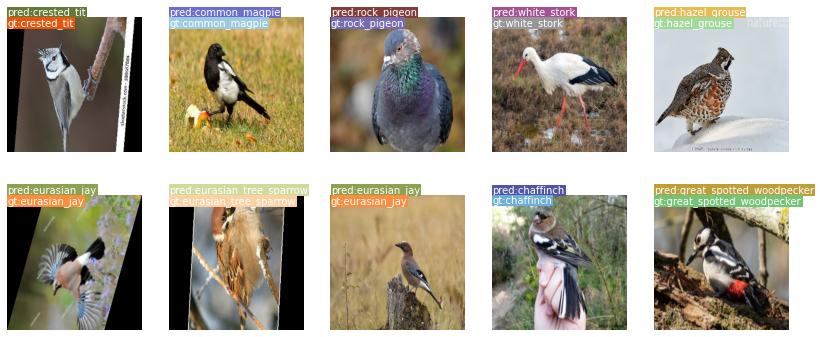

In [ ]:
show_img_n_lbl(val_set, is_labels_pred=True)

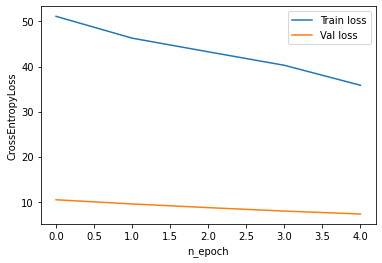

In [ ]:
fig, ax = plt.subplots()

n_epoch = range(EPOCHES)
ax.plot(n_epoch, train_loss_per_epoche, label="Train loss")
ax.plot(n_epoch, val_loss_per_epoche, label="Val loss")
ax.set_xlabel('n_epoch')
ax.set_ylabel('CrossEntropyLoss')
ax.legend()

plt.show()